In [1]:
from pathlib import Path
import os

import requests
import tarfile

from tqdm import tqdm
from collections import defaultdict

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from IPython.display import clear_output

import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import InterpolationMode
from torchvision.transforms import v2
import torch.nn.functional as F

from torch.optim.lr_scheduler import MultiStepLR
from torch.optim import AdamW

from scipy.ndimage import label
from scipy.spatial import ConvexHull

from skimage import measure
from skimage.draw import line, polygon
from skimage.color import label2rgb

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

NVIDIA GeForce RTX 3060


device(type='cuda', index=0)

In [3]:
IMG_SIZE = 224
ORIG_SIZE = 700

PROJECT_ROOT = Path.cwd()
PROJECT_ROOT

WindowsPath('G:/PycharmProjects/Segmentation/dev_files/old')

## Import dataset

In this work I will use the MVTec AD dataset. It is not intended for commercial use. 

Link to the dataset: https://www.mvtec.com/company/research/datasets/mvtec-ad. 

MVTec AD is a dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains images of various objects (carpet, metal_nut): the train part contains images of only good products, the test part contains classified images of defective products and defect segmentation masks.

In [4]:
# Dataset MVTec AD info: https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads

download_links = {
    'metal_nut': 'https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz',
    'carpet': 'https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz',
    'pill': 'https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz',
}

Check if the dataset is installed. If not - it will be installed

In [5]:
obj = 'metal_nut'
if not os.path.exists(PROJECT_ROOT / 'data' / 'MVTecAD' / obj):
    response = requests.get(
        download_links[obj],
        stream=True)
    with open(f"{obj}.tar.xz", "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    
    with tarfile.open(f"{obj}.tar.xz", "r:xz") as tar_ref:
            tar_ref.extractall(PROJECT_ROOT / 'data' / 'MVTecAD', filter="data")
    os.remove(f"{obj}.tar.xz")
    print('Dataset has been installed successfully')
else:
    print('Dataset already exists')

Dataset already exists


Custom class for getting image, mask and defect label

In [6]:
class MVTecSegmentationDataset(Dataset):
    def __init__(self, root, joint_transform=None, image_transform=None, mask_transform=None,
                 train=True, image_paths=None, masks=None, labels=None):
        """
        root: path to object (e.g. metal_nut)
        train: True for train, False for test
        joint_transform: transformations, apply to image and mask simultaneously
        image_transform: transformations only for image
        mask_transform: transformations only for mask
        image_paths, masks, labels: ready results (for split_dataset)
        """
        self.root = root
        self.train = train
        self.joint_transform = joint_transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        if image_paths is not None:
            self.image_paths = image_paths
            self.masks = masks
            self.labels = labels
            return

        if train:
            self.image_paths = sorted(
                [os.path.join(root, 'train', 'good', f) 
                 for f in os.listdir(os.path.join(root, 'train', 'good')) 
                 if f.endswith(('.png', '.jpg'))]
            )
            self.masks = [None] * len(self.image_paths)
            self.labels = ["good"] * len(self.image_paths)
        else:
            self.image_paths = []
            self.masks = []
            self.labels = []

            test_dir = os.path.join(root, 'test')
            gt_dir = os.path.join(root, 'ground_truth')

            for defect_name in sorted(os.listdir(test_dir)):
                defect_path = os.path.join(test_dir, defect_name)
                if not os.path.isdir(defect_path):
                    continue
                files = sorted([f for f in os.listdir(defect_path) if f.endswith(('.png', '.jpg'))])
                for img_file in files:
                    self.image_paths.append(os.path.join(defect_path, img_file))
                    if defect_name == 'good':
                        self.masks.append(None)
                        self.labels.append('good')
                    else:
                        mask_name = img_file.replace('.png', '_mask.png')
                        mask_path = os.path.join(gt_dir, defect_name, mask_name)
                        self.masks.append(mask_path)
                        self.labels.append(defect_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.masks[idx]
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert("L") if mask_path else Image.new("L", image.size, 0)

        if self.joint_transform:
            image, mask = self.joint_transform(image, mask)
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
    
        label = self.labels[idx]
    
        return {
            'image': image,
            'mask': mask,
            'label': label
        }

    def split_dataset(self, share=0.7):
        """
        Splits the dataset into 2 parts (for example 70% and 30%), 
        preserving the proportions of files inside each folder (defect/good).
        """
        if self.train:
            n_total = len(self.image_paths)
            n_first = round(n_total * share)
            return (
                MVTecSegmentationDataset(self.root, self.joint_transform, self.image_transform, self.mask_transform,
                                         self.train, self.image_paths[:n_first], self.masks[:n_first], self.labels[:n_first]),
                MVTecSegmentationDataset(self.root, self.joint_transform, self.image_transform, self.mask_transform,
                                         self.train, self.image_paths[n_first:], self.masks[n_first:], self.labels[n_first:])
            )

        # For test devision by classes (folders)
        first_paths, first_masks, first_labels = [], [], []
        second_paths, second_masks, second_labels = [], [], []

        groups = defaultdict(list)
        for p, m, l in zip(self.image_paths, self.masks, self.labels):
            groups[l].append((p, m))

        for label, items in groups.items():
            n_total = len(items)
            n_first = round(n_total * share)

            first = items[:n_first]
            second = items[n_first:]

            for p, m in first:
                first_paths.append(p)
                first_masks.append(m)
                first_labels.append(label)

            for p, m in second:
                second_paths.append(p)
                second_masks.append(m)
                second_labels.append(label)

        return (
            MVTecSegmentationDataset(self.root, self.joint_transform, self.image_transform, self.mask_transform,
                                     self.train, first_paths, first_masks, first_labels),
            MVTecSegmentationDataset(self.root, self.joint_transform, self.image_transform, self.mask_transform,
                                     self.train, second_paths, second_masks, second_labels)
        )

I will use the outputs of Resnet50 layers trained on ImageNet, so I will apply ImageNet normalization. 

I also write the inverse function - denormalize() to return the original image.

In [7]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def denormalize(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    mean = torch.tensor(mean, device=img_tensor.device).view(-1, 1, 1)
    std = torch.tensor(std, device=img_tensor.device).view(-1, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

joint_transforms = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  # convert to [0,1]
])

img_transforms = v2.Compose([
    v2.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

The train part will be used to form the memory_bank, as it contains only defect-free objects. 

To refine the segmentation masks, I will take 70% of the test part, containing both defects and good objects, and the remaining 30% will be the test part.

In [8]:
root = str(PROJECT_ROOT / 'data' / 'MVTeCAD' / obj)

train_dataset = MVTecSegmentationDataset(
    root=root,
    train=True,
    joint_transform=joint_transforms,
    image_transform=img_transforms,
)

train_loader = DataLoader(
    train_dataset, 
	batch_size=8,  
    #num_workers=8, 
    pin_memory=True
)


test_dataset = MVTecSegmentationDataset(
    root=root,
    train=False,
    joint_transform=joint_transforms,
    image_transform=img_transforms,
)

train_seg_set_75, test_seg_set_25 = test_dataset.split_dataset(share=0.75)
train_seg_set_50, valid_seg_set_25 = test_dataset.split_dataset(share=0.66)

segm_train_loader = DataLoader(
    train_seg_set_50, 
	batch_size=6,  
    #num_workers=8, 
    pin_memory=True
)

segm_val_loader = DataLoader(
    valid_seg_set_25, 
	batch_size=6,  
    #num_workers=8, 
    pin_memory=True
)

segm_test_loader = DataLoader(
    test_seg_set_25, 
	batch_size=6,  
    #num_workers=8, 
    pin_memory=True
)

labels = set()
idx = list()
for i, im in enumerate(test_seg_set_25):
    if im['label'] not in labels:
        idx.append(i)
        labels.add(im['label'])

subset = Subset(test_seg_set_25, idx)

visualize_loader = DataLoader(subset, batch_size=len(subset), shuffle=False)

# Formation of memory_bank

## Class for getting patches

The core idea behind PatchCore, which serves as the foundation of this project, is to compute the distance to the nearest neighbor between a pixel embedding vector and the embedding vectors stored in the memory_bank.

To extract patch vectors, I will use the outputs from the second and third layers of ResNet50.

In [9]:
class ResNetEmbeddings(nn.Module):
    def __init__(self, pool_kernel=3, pool_stride=1, return_first_layers=False):
        super().__init__()

        self.return_first_layers = return_first_layers
        
        # Loading the pre-trained ResNet50        
        self.model = resnet50(
            weights=ResNet50_Weights.IMAGENET1K_V2
        )
        self.model.eval()

        # Freezing weights
        for p in self.model.parameters():
            p.requires_grad = False
            
        self.avg_pool = nn.AvgPool2d(pool_kernel, stride=pool_stride)

        # Containers for features and handles
        self._features = {}
        self.handles = {}

        # Hook
        def make_hook(name):
            def hook(module, input, output):
                self._features[name] = output
            return hook

        # Hooks
        if self.return_first_layers:
            self.handles["conv1"]  = self.model.conv1.register_forward_hook(make_hook("conv1"))
            self.handles["layer1"] = self.model.layer1[-1].register_forward_hook(make_hook("layer1"))
            
        self.handles["layer2"] = self.model.layer2[-1].register_forward_hook(make_hook("layer2"))
        self.handles["layer3"] = self.model.layer3[-1].register_forward_hook(make_hook("layer3"))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Returns patches [B, H*W, C]"""
        self._features = {}
        with torch.no_grad():
            _ = self.model(x)

        # resize
        resize = nn.AdaptiveAvgPool2d(self._features['layer2'].shape[-2:]) # [B, C, H, W]

        # Glue by N
        fused = torch.cat([resize(self.avg_pool(fmap)) for fmap in [self._features['layer2'], self._features['layer3']]], dim=1)  # [B, C, H,W]

        # Convert to patches: [B, H*W, C]
        patches = fused.flatten(2).permute(0, 2, 1).contiguous()

        if self.return_first_layers:
            return patches, self._features
        else:
            return patches

    def close(self):
        """Removes hooks"""
        for h in self.handles.values():
            h.remove()

In [10]:
def extract_features(loader, backbone=None, device=device, return_embeddings=False):
    """Function for forming a memory bank"""
    if not backbone:
        backbone = ResNetEmbeddings(return_first_layers=return_embeddings).to(device)
    features = []
    backbone.eval().to(device)
    embs = []
    with torch.no_grad():
        for batch in loader:
            imgs = batch['image'].to(device)
            if return_embeddings:
                output, embeddings = backbone(imgs)
                embs.append(embeddings)
            else:
                output = backbone(imgs)
            features.append(output.to('cpu'))
    if return_embeddings:
        return torch.cat(features, dim=0), embs
    else:
        return torch.cat(features, dim=0)

## Memory bank compression

memory_bank contains patches from all images in the training set. 

The difference between them may be small, so it is possible to compress memory_bank by excluding duplicate patches without losing quality

In [11]:
def compress_mb(memory_bank, budget, batch_size=50000, device=device, verbose=True):
    """
    Batch version of k-center greedy for large memory_banks
    
    budget: number of patches to select
    batch_size: batch size for calculating distances
    """
    N, C = memory_bank.shape
    memory_bank = memory_bank.to(device)
    
    # Initialization: random first element
    idxs = [torch.randint(0, N, (1,), device=device).item()]
    
    # Minimum distances to selected elements
    dist = torch.full((N,), float('inf'), device=device)
    
    for i in range(budget-1):
        # Calculate distances by batches
        new_center = memory_bank[idxs[-1]].unsqueeze(0)  # [1, C]
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            batch = memory_bank[start:end]  # [batch_size, C]
            dists = torch.norm(batch - new_center, dim=1)
            dist[start:end] = torch.minimum(dist[start:end], dists)
        
        # The next element is the farthest one
        next_idx = torch.argmax(dist).item()
        idxs.append(next_idx)
        
        if verbose and ((i+1) % (budget // 10) == 0 or i == budget-1):
            print(f"[{i+1}/{budget}] selected elements")

    return memory_bank[torch.tensor(idxs, dtype=torch.long, device='cpu')]

In [12]:
%%time
memory_bank = extract_features(train_loader)
size = int(np.sqrt(memory_bank.shape[1]))
memory_bank = memory_bank.reshape(-1, memory_bank.shape[-1])
print("Memory bank shape:", memory_bank.shape)
print("Mask size:", size)

memory_bank = compress_mb(memory_bank, budget=25000, batch_size=50000)
print("Redused memory bank shape:", memory_bank.shape)
print()

Memory bank shape: torch.Size([172480, 1536])
Mask size: 28
[2500/25000] selected elements
[5000/25000] selected elements
[7500/25000] selected elements
[10000/25000] selected elements
[12500/25000] selected elements
[15000/25000] selected elements
[17500/25000] selected elements
[20000/25000] selected elements
[22500/25000] selected elements
Redused memory bank shape: torch.Size([25000, 1536])

CPU times: total: 4min 25s
Wall time: 4min 5s


## Define threshold

Now I need to determine the minimum distances between two objects inside the memory_bank.

Since I will determine the distances on patches obtained on the same images (from the training set), I will take the 2 nearest neighbors, determine the median value among the distances to the nearest neighbor and apply the distance to the nearest neighbor if it is higher than the median and the distance to the second neighbor if it is lower than the median.

In [13]:
def explore_bank(loader=train_loader, backbone=None, memory_bank=memory_bank, size=size, device=device):
    memory_bank = memory_bank.to(device)
    if not backbone:
        backbone = ResNetEmbeddings(return_first_layers=False)
    
    backbone.eval().to(device)
    results = []
    with torch.no_grad():
        for batch in tqdm(loader, ncols=80):
            imgs = batch['image'].to(device)
            distances = torch.topk(torch.cdist(backbone(imgs).reshape(-1, memory_bank.shape[-1]), memory_bank), dim=1, k=2, largest=False)[0].cpu()
            median = distances.median(dim=0)[0][0]
            mask_gt = distances[:, 0] > median
            mask_le = ~mask_gt 
            
            result = torch.empty(distances.size(0), dtype=distances.dtype)
            result[mask_gt] = distances[mask_gt, 0]
            result[mask_le] = distances[mask_le, 1]
            results.append(result)
    return torch.cat(results, dim=0)

In [14]:
min_distances = explore_bank()

100%|███████████████████████████████████████████| 28/28 [00:05<00:00,  4.88it/s]


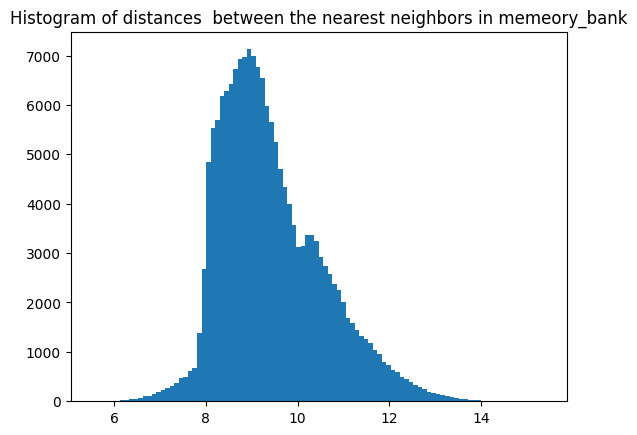

In [15]:
plt.hist(min_distances, bins=100)
plt.title('Histogram of distances  between the nearest neighbors in memeory_bank')
plt.show()

In [16]:
print(f'median: {min_distances.median().item():.2f}')
print(f'std: {min_distances.std().item():.2f}')
print(f'max: {min_distances.max().item():.2f}')

median: 9.21
std: 1.13
max: 15.37


# Inference

In [17]:
def find_threshold(segm_map, real_mask, linspace=np.linspace(0.0, 1.0, 201)):
    res = []
    
    for i in linspace:
        res.append(dice_metric(segm_map, real_mask, i))
    return linspace[np.argmax(res)].item()


def make_bboxes_batch(masks):
    if isinstance(masks, np.ndarray):
        masks = torch.from_numpy(masks).detach()
    
    if masks.ndim == 4 and masks.shape[1] == 1:
        masks = masks[:, 0]  # [B, H, W]

    bboxes_batch = []
    if masks.ndim == 2:
        masks = masks.unsqueeze(0)
    for mask in masks:
        labels = measure.label(mask, connectivity=2)
        bboxes = []
        for region in measure.regionprops(labels):
            minr, minc, maxr, maxc = region.bbox
            bboxes.append((minc, minr, maxc, maxr))  # [xmin, ymin, xmax, ymax]
        bboxes_batch.append(bboxes)

    return bboxes_batch

def draw_bboxes_batch(bboxes, ax=None, color='red'):
    if not ax:
        ax = plt.gca()
    for (xmin, ymin, xmax, ymax) in bboxes:
        ax.add_patch(
            plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                          edgecolor=color, facecolor='none', linewidth=3)
        )

In [18]:
def inference(
    loader, 
    backbone=None, 
    device=device, 
    memory_bank=memory_bank,
    min_distances=min_distances, 
    visualize=False, 
    return_mask=False,
    return_heatmap=False,
    IMG_SIZE=IMG_SIZE, 
    threshold=0.5
):
    """
    Performs anomaly detection on images using a feature backbone and a memory bank of embeddings. 
    Can return heatmaps, binary masks, or visualizations comparing predictions to ground truth masks.

    Args:
        loader (torch.utils.data.DataLoader): DataLoader providing batches of images and masks.
        backbone (torch.nn.Module, optional): Feature extractor network. If None, uses ResNetEmbeddings by default.
        device (torch.device, optional): Device to perform computations on (CPU or GPU).
        memory_bank (torch.Tensor): Precomputed embeddings of normal patches for anomaly comparison.
        min_distances (torch.Tensor): Tensor containing minimum distances used for normalization of heatmaps.
        visualize (bool, optional): If True, shows visual comparison between input, predicted heatmaps, and masks.
        return_mask (bool, optional): If True, returns binary anomaly masks based on the threshold.
        return_heatmap (bool, optional): If True, returns continuous anomaly heatmaps.
        IMG_SIZE (int, optional): Size to which the heatmaps are upsampled for visualization or output.
        threshold (float, optional): Threshold for converting heatmaps to binary masks.

    Returns:
        torch.Tensor: Depending on `return_mask` and `return_heatmap`:
            - If `return_mask=True`, returns a tensor of shape (N, 1, IMG_SIZE, IMG_SIZE) with binary anomaly masks.
            - If `return_heatmap=True`, returns a tensor of shape (N, 1, IMG_SIZE, IMG_SIZE) with continuous anomaly heatmaps.
            - If neither is True, returns None (useful if `visualize=True` only).
    Notes:
        - The function computes distances between the feature embeddings of image patches and the memory bank.
        - Heatmaps are normalized using the provided `min_distances`.
    """
    def make_visualization(image, primary_heatmap, heatmap, real_mask, threshold=threshold, draw_bboxes=True):

        """
        Visualization shows five images side by side:
            1. Input image
            2. Raw distances from the backbone
            3. Normalized/interpolated distances (heatmap)
            4. Predicted binary mask
            5. Ground truth mask
        """

        fig, axes = plt.subplots(1, 5, figsize=(16, 5))

        normal_max = 0.5  # acceptable threshold
        anom_max = 1  # extreme anomalies
        norm = Normalize(vmin=normal_max, vmax=anom_max, clip=True)
    
        axes[0].imshow(image.permute(1,2,0))
        axes[1].imshow(primary_heatmap.cpu().numpy(), cmap='gray')
        axes[2].imshow(heatmap.cpu(), cmap='Reds', norm=norm)
        axes[3].imshow((heatmap.cpu() > threshold).int(), cmap='gray')
        axes[4].imshow(real_mask.squeeze(), cmap='gray')
        
        axes[0].set_title('input object')
        axes[1].set_title('calculated distances')
        axes[2].set_title('interpolated distances')
        axes[3].set_title('predicted mask')
        axes[4].set_title('real mask')

        if draw_bboxes:
            bboxes = make_bboxes_batch((heatmap.cpu() > threshold).int())
            draw_bboxes_batch(bboxes[0], ax=axes[0])
            draw_bboxes_batch(bboxes[0], ax=axes[3])
            draw_bboxes_batch(bboxes[0], ax=axes[4])

            real_bboxes = make_bboxes_batch(real_mask.squeeze().cpu())
            draw_bboxes_batch(real_bboxes[0], ax=axes[0], color='yellow')
            draw_bboxes_batch(real_bboxes[0], ax=axes[3], color='yellow')
            draw_bboxes_batch(real_bboxes[0], ax=axes[4], color='yellow') 
        
        plt.show()
    if visualize:
        images = []
        primary_heatmaps = []
        real_masks = []
    
    if not backbone:
        backbone = ResNetEmbeddings(return_first_layers=False).to(device)
    features = []
    backbone.eval().to(device)
    embs = []
    with torch.no_grad():
        for batch in loader:
            imgs = batch['image']
            if visualize:
                images.append(imgs)
                real_masks.append(batch['mask'])
            
            imgs = imgs.to(device)
            output = backbone(imgs)
            features.append(output)
        patches = torch.cat(features, dim=0)

    size = int(np.sqrt(patches.shape[1]))

    memory_bank = memory_bank.to(device)

    heat = []
    
    for patch in patches:
        patch = patch.unsqueeze(0)
        dist = torch.cdist(patch, memory_bank)
        heatmap = dist.min(dim=2)[0].reshape(1, 1, size, size)
        heatmap = (heatmap - torch.quantile(min_distances, 0.95)) / 10 # 0.65

        
        heat.append(heatmap)
    heatmaps = torch.cat(heat, dim=0)
    if visualize:
        primary_heatmaps.append(heatmaps)

    heatmaps = F.interpolate(
        heatmaps,
        size=(IMG_SIZE, IMG_SIZE),
        mode='bilinear',
        align_corners=False
    )    
    
    heatmaps = torch.sigmoid(heatmaps)

    if visualize:
        images = torch.cat(images, dim=0)
        primary_heatmaps = torch.cat(primary_heatmaps, dim=0)
        real_masks = torch.cat(real_masks, dim=0)

        for _idx in range(images.shape[0]):
            make_visualization(
                denormalize(images[_idx]), 
                primary_heatmaps[_idx].squeeze(), 
                heatmaps[_idx].squeeze(), 
                real_masks[_idx].squeeze()
            )

    if return_mask:
        return (heatmaps>threshold).int().cpu()
    if return_heatmap:
        return heatmaps.cpu()

As a loss function I will use Binary Cross-Entropy (BCE) + Dice loss.

Dice will be used as a metric

In [19]:
def dice_score(pred: torch.Tensor, target: torch.Tensor, threshold: float = None, eps: float = 1e-6):
    """
    Calcualte Dice for probabilities or binary masks

    pred: [B, 1, H, W] — probabilities or logits
    target: [B, 1, H, W] — binary masks {0,1}
    threshold: float or None
    """
    if pred.dtype == torch.float32 and threshold is not None:
        # probabilities binarization
        pred = (pred > threshold).float()

    if pred.max() > 1.0 or pred.min() < 0.0:
        pred = torch.sigmoid(pred)
    
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    
    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean()

def dice_metric(prob_map, target, threshold=0.5):
    return dice_score(prob_map, target, threshold=threshold).item()

# BCE + Dice Loss
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, logits, target):
        bce_loss = self.bce(logits, target)
        d_loss = 1 - dice_score(logits, target) # Dice loss
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * d_loss

In [20]:
all_preds = inference(segm_val_loader, return_heatmap=True)

all_targets = []
for batch in segm_val_loader:
    all_targets.append(batch['mask'])
all_targets = torch.cat(all_targets, dim=0)

threshold = find_threshold(all_preds, all_targets)
print(threshold)

0.63


In [21]:
all_preds = inference(segm_test_loader, return_heatmap=True)

all_targets = []
for batch in segm_test_loader:
    all_targets.append(batch['mask'])
all_targets = torch.cat(all_targets, dim=0)
total_metric = dice_metric(
        all_preds.cpu(), 
        all_targets.cpu().float()
)
print(f"Dice score on test sample: {total_metric:.4f}")

Dice score on test sample: 0.2693


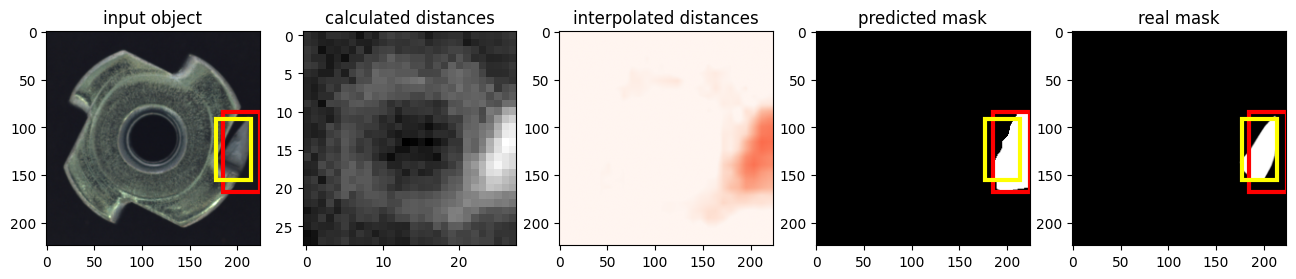

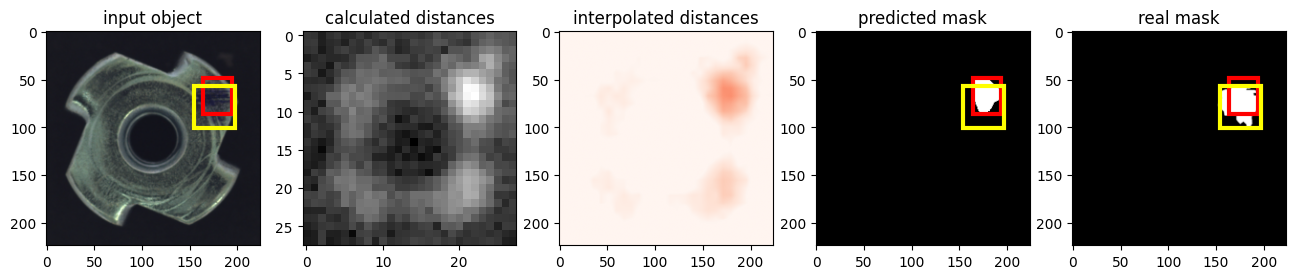

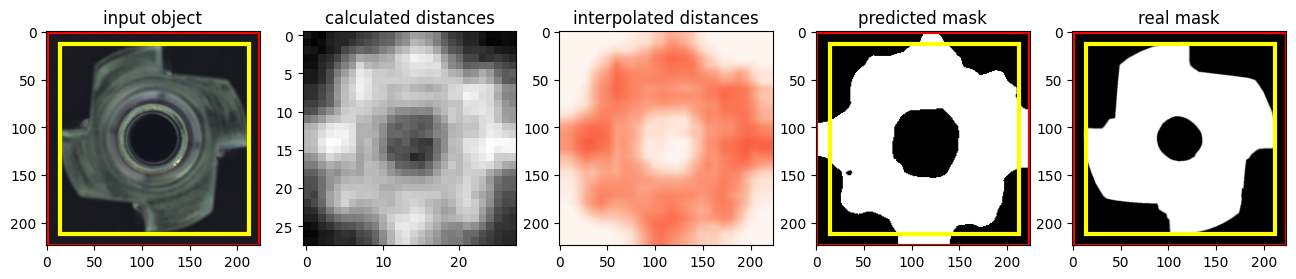

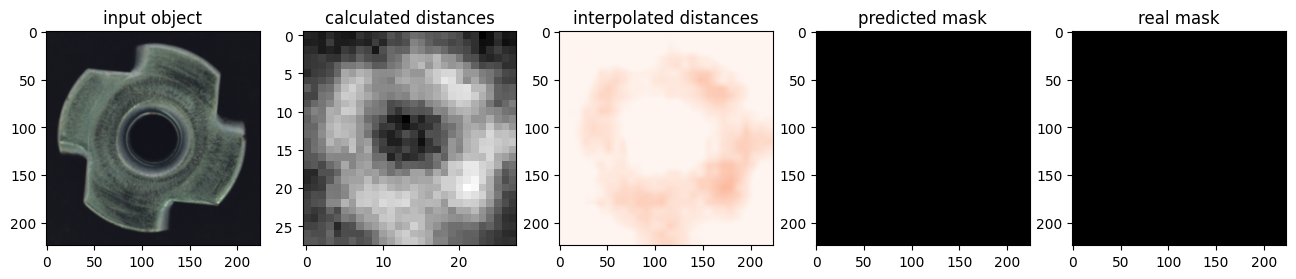

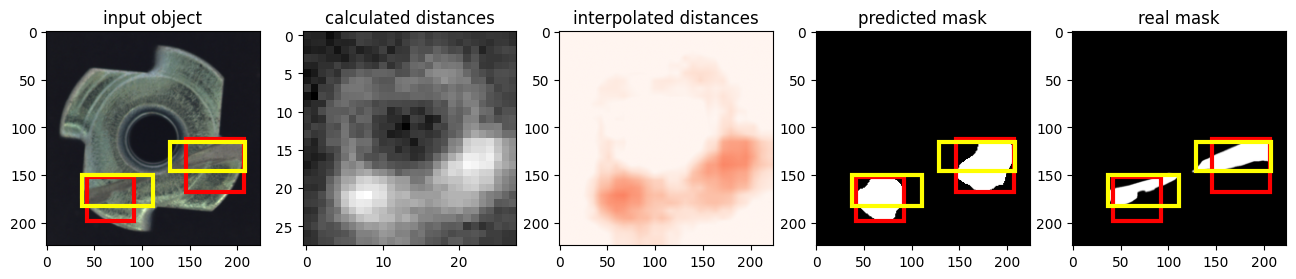

In [22]:
inference(visualize_loader, visualize=True, threshold=threshold)

The result is a model that defines the area of ​​the defect well, but it is too blurry

## Class for models

### Simple

Сlass repeating the model above

In [23]:
class MemoryNet(nn.Module):
    def __init__(self, memory_bank, min_distances, pool_kernel=3, pool_stride=1, threshold=0.5):
        super().__init__()
        
        self.memory_bank = memory_bank
        self.min_distances = min_distances
        self.max_d = torch.max(min_distances).item()

        # threshold
        self.register_buffer("threshold", torch.tensor(threshold))

        # Loading the pre-trained ResNet50       
        self.model = resnet50(
            weights=ResNet50_Weights.IMAGENET1K_V2
        )
        self.model.eval()

        # Freezing weights
        for p in self.model.parameters():
            p.requires_grad = False

        self.avg_pool = nn.AvgPool2d(pool_kernel, stride=pool_stride)

        # Containers for features and handles
        self._features = {}
        self.handles = {}

        # Hook
        def make_hook(name):
            def hook(module, input, output):
                self._features[name] = output
            return hook

        # Hooks
        self.handles["conv1"]  = self.model.conv1.register_forward_hook(make_hook("conv1"))
        self.handles["layer1"] = self.model.layer1[-1].register_forward_hook(make_hook("layer1"))
        self.handles["layer2"] = self.model.layer2[-1].register_forward_hook(make_hook("layer2"))
        self.handles["layer3"] = self.model.layer3[-1].register_forward_hook(make_hook("layer3"))


    def forward(self, x):
        """Returns heatmap [B, 1, H, W] for binary segmentation"""
        self._features = {}
        
        # Getting features from ResNet
        with torch.no_grad():
            _ = self.model(x)  # [B, C, H, W]
    
        # Aggregate layer2 and layer3 features
        target_size = self._features['layer2'].shape[-2:]  # H, W
        fused = torch.cat([
            F.adaptive_avg_pool2d(self.avg_pool(self._features['layer2']), target_size),
            F.adaptive_avg_pool2d(self.avg_pool(self._features['layer3']), target_size)
        ], dim=1)  # [B, C, H, W]
    
        # Convert to patches for comparison with memory_bank
        B, C, H, W = fused.shape
        patches = fused.flatten(2).permute(0, 2, 1).contiguous()  # [B, H*W, C]
    
        memory_bank_device = self.memory_bank.to(patches.device)
        
        dist = torch.cdist(patches, memory_bank_device)  # [B, H*W, N_memory]
        heatmap = dist.min(dim=2)[0].reshape(B, 1, H, W)  # [B, 1, H, W]

        # Scaling
        # heatmap = (heatmap - self.min_distances.mean()) / self.min_distances.std() / 3 - 1 # 0.75
        heatmap = (heatmap - torch.quantile(self.min_distances, 0.95)) / 10 # 0.65

        input_size = x.shape[-2:]
    
        heatmap = F.interpolate(
            heatmap,
            size=input_size,
            mode='bilinear',
            align_corners=False
        )    
        return heatmap

### Refined mask model

To refine the masks I will use the heatmap output from the previous model, as well as the outputs from the resnet50 layers. 

Next I will make a U-Net like (only part of the increase) segmentation model

In [24]:
class UpMemoryNet(nn.Module):
    def __init__(self, memory_bank, min_distances, pool_kernel=3, pool_stride=1, threshold=0.5):
        super().__init__()
        
        self.memory_bank = memory_bank
        self.min_distances = min_distances
        self.max_d = torch.max(min_distances).item()
        
        # threshold 
        self.register_buffer("threshold", torch.tensor(threshold))


        # Loading the pre-trained ResNet50          
        self.model = resnet50(
            weights=ResNet50_Weights.IMAGENET1K_V2
        )
        self.model.eval()

        # Freezing weights
        for p in self.model.parameters():
            p.requires_grad = False
            
        self.avg_pool = nn.AvgPool2d(pool_kernel, stride=pool_stride)

        # Containers for features and handles
        self._features = {}
        self.handles = {}

        # Hook
        def make_hook(name):
            def hook(module, input, output):
                self._features[name] = output
            return hook

        # Hooks
        self.handles["conv1"]  = self.model.conv1.register_forward_hook(make_hook("conv1"))
        self.handles["layer1"] = self.model.layer1[-1].register_forward_hook(make_hook("layer1"))
        self.handles["layer2"] = self.model.layer2[-1].register_forward_hook(make_hook("layer2"))
        self.handles["layer3"] = self.model.layer3[-1].register_forward_hook(make_hook("layer3"))
        
        self.up = nn.Sequential(
            nn.Conv2d(
                in_channels=65,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2)
        )

        self.out = nn.Conv2d(
                in_channels=16+3,
                out_channels=1,
                kernel_size=3,
                stride=1,
                padding=1
            )


    def forward(self, x):
        """Returns heatmap [B, 1, H, W] for binary segmentation"""
        self._features = {}
    
        # Getting features from ResNet
        with torch.no_grad():
            _ = self.model(x)  # [B, C, H, W]
    
        # Aggregate layer2 and layer3 features
        target_size = self._features['layer2'].shape[-2:]  # H, W
        fused = torch.cat([
            F.adaptive_avg_pool2d(self.avg_pool(self._features['layer2']), target_size),
            F.adaptive_avg_pool2d(self.avg_pool(self._features['layer3']), target_size)
        ], dim=1)  # [B, C_total, H, W]
    
        # Convert to patches for comparison with memory_bank
        B, C, H, W = fused.shape
        patches = fused.flatten(2).permute(0, 2, 1).contiguous()  # [B, H*W, C]
    
        memory_bank_device = self.memory_bank.to(patches.device)
        
        dist = torch.cdist(patches, memory_bank_device)  # [B, H*W, N_memory]
        heatmap = dist.min(dim=2)[0].reshape(B, 1, H, W)  # [B, 1, H, W]

        heatmap = heatmap / self.max_d
    
        # Interpolation and concatenation with conv1
        conv1_size = self._features['conv1'].shape[-2:]
        heatmap = F.interpolate(heatmap, size=conv1_size, mode='bilinear', align_corners=False)
        heatmap = torch.cat([heatmap, self._features['conv1']], dim=1)
        heatmap = self.up(heatmap)
    
        # Interpolate to original size and concatenation with the image
        input_size = x.shape[-2:]
        heatmap = F.interpolate(heatmap, size=input_size, mode='bilinear', align_corners=False)
        heatmap = torch.cat([heatmap, x], dim=1)
        heatmap = self.out(heatmap)  # [B, 1, H, W]
    
        return heatmap

In [25]:
print('Number of parameters by model layers:')
for name, p in UpMemoryNet(memory_bank, min_distances).named_parameters():
    if p.requires_grad:
        print(name, p.numel())

print()
print('Total number of parameters:')
print(sum(p.numel() for p in UpMemoryNet(memory_bank, min_distances).parameters() if p.requires_grad))

Number of parameters by model layers:
up.0.weight 18720
up.0.bias 32
up.1.weight 32
up.1.bias 32
up.3.weight 4608
up.3.bias 16
up.4.weight 16
up.4.bias 16
out.weight 171
out.bias 1

Total number of parameters:
23644


In [26]:
def merge_islands(arr, threshold=2):
    """
    Model outputs can be separated. Combines closely spaced areas
    """
    arr = arr.numpy().astype(bool)
    labeled, n = label(arr)
    merged = arr.copy()

    # getting the coordinates of the islands
    islands = []
    for i in range(1, n + 1):
        coords = np.argwhere(labeled == i)
        islands.append(coords)

    for i in range(len(islands)):
        for j in range(i + 1, len(islands)):
            c1, c2 = islands[i], islands[j]

            # minimum distance between islands
            dists = np.linalg.norm(c1[:, None, :] - c2[None, :, :], axis=2)
            min_dist = dists.min()

            if min_dist <= threshold:
                # connect the dots of two islands
                pts = np.vstack([c1, c2])
                # construct a convex hull
                hull = ConvexHull(pts)
                poly = pts[hull.vertices]
                rr, cc = polygon(poly[:, 0], poly[:, 1], arr.shape)
                merged[rr, cc] = 1

    return merged.astype(np.uint8)

In [35]:
def train(model, loader, optimizer, loss_fn) -> tuple[float, float]:
    """Train the neural network"""
    model.train()

    train_loss = 0
    metric = 0

    for batch in tqdm(loader, desc='Train', ncols=80):
        x = batch['image'].to(device)
        y = batch['mask'].to(device).float()  # BCEWithLogitsLoss expects float

        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        metric += dice_metric(torch.sigmoid(output), y, model.threshold.item())

    avg_loss = train_loss / len(loader)
    avg_metric = metric / len(loader)
    return avg_loss, avg_metric


@torch.inference_mode()
def evaluate(model, loader, loss_fn) -> tuple[float, float]:
    """Measure the quality of the model on the test set"""
    model.eval()

    total_loss = 0
    metric = 0

    for batch in tqdm(loader, desc='Evaluation', ncols=80):
        x = batch['image'].to(device)
        y = batch['mask'].to(device).float()  # [B, H, W]

        output = model(x)  # [B, 1, H, W]

        loss = loss_fn(output, y)  # output: [B,H,W], y: [B,H,W]
        
        total_loss += loss.item()
        metric += dice_metric(torch.sigmoid(output), y, model.threshold.item())

    avg_loss = total_loss / len(loader)
    avg_metric = metric / len(loader)
    return avg_loss, avg_metric

def update_threshold(model, loader):
    """Iterate over the threshold throughout the validation"""
    all_preds, all_targets = [], []

    with torch.inference_mode():
        for batch in tqdm(loader, desc='Find threshold', ncols=80) :
            x = batch['image'].to(device)
            y = batch['mask'].to(device).float()

            output = torch.sigmoid(model(x))
            all_preds.append(output.cpu())
            all_targets.append(y.cpu())

    segm_map = torch.cat(all_preds, dim=0)
    real_mask = torch.cat(all_targets, dim=0)

    model.threshold.fill_(find_threshold(segm_map, real_mask))

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_score: list[float],
    valid_score: list[float],
    title: str
):
    """Plots model quality graphs"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # --- Loss ---
    axes[0].set_title(title + ' loss')
    axes[0].plot(train_loss, label='Train loss')
    axes[0].plot(valid_loss, label='Valid loss')
    axes[0].legend()
    axes[0].grid()

    # --- Metric ---
    axes[1].set_title(title + ' dice')
    axes[1].plot(train_score, label='Train dice')
    axes[1].plot(valid_score, label='Valid dice')
    axes[1].legend()
    axes[1].grid()

    plt.show()


def whole_train_valid_cycle(model, num_epochs, title, train_loader, valid_loader, thr_loader, optimizer, loss_fn, scheduler=None):
    train_loss_history, valid_loss_history = [], []
    train_metric_history, valid_metric_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_metric = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_metric = evaluate(model, valid_loader, loss_fn)

        # after validation - update threshold
        update_threshold(model, thr_loader)
        
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_metric_history.append(train_metric)
        valid_metric_history.append(valid_metric)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_metric_history, valid_metric_history,
            title
        )
        scheduler.step()  # change optimization step

@torch.inference_mode()
def visualize(model, batch, threshold=0.5, draw_bboxes=True):
    model.eval()

    xs = batch['image']
    ys = batch['mask']
    
    to_pil = v2.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        
        output = model(x.unsqueeze(0).to(device))
        prediction = (torch.sigmoid(output.squeeze()) > threshold).to(torch.uint8)
        
        #prediction = merge_islands(prediction.cpu(), threshold=15) # merging_islands

        prediction = prediction.cpu()

        fig, ax = plt.subplots(1, 4, figsize=(16, 9), facecolor='white')

        ax[0].imshow(to_pil(denormalize(x)))
        ax[1].imshow(to_pil(torch.sigmoid(output.squeeze(0))), cmap='Reds')
        ax[2].imshow(to_pil(prediction), cmap='gray')
        ax[3].imshow(to_pil(y.to(torch.uint8)), cmap='gray')
        
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        ax[3].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Output heatmap')
        ax[2].set_title('Prediction')
        ax[3].set_title('Segmentation mask')
        
        if draw_bboxes:
            bboxes = make_bboxes_batch(prediction)
            draw_bboxes_batch(bboxes[0], ax=ax[0])
            draw_bboxes_batch(bboxes[0], ax=ax[2])
            draw_bboxes_batch(bboxes[0], ax=ax[3])

            real_bboxes = make_bboxes_batch(y.cpu())
            draw_bboxes_batch(real_bboxes[0], ax=ax[0], color='yellow')
            draw_bboxes_batch(real_bboxes[0], ax=ax[2], color='yellow')
            draw_bboxes_batch(real_bboxes[0], ax=ax[3], color='yellow')

        plt.subplots_adjust(wspace=0.01, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [28]:
loss_fn = BCEDiceLoss(bce_weight=0.7)

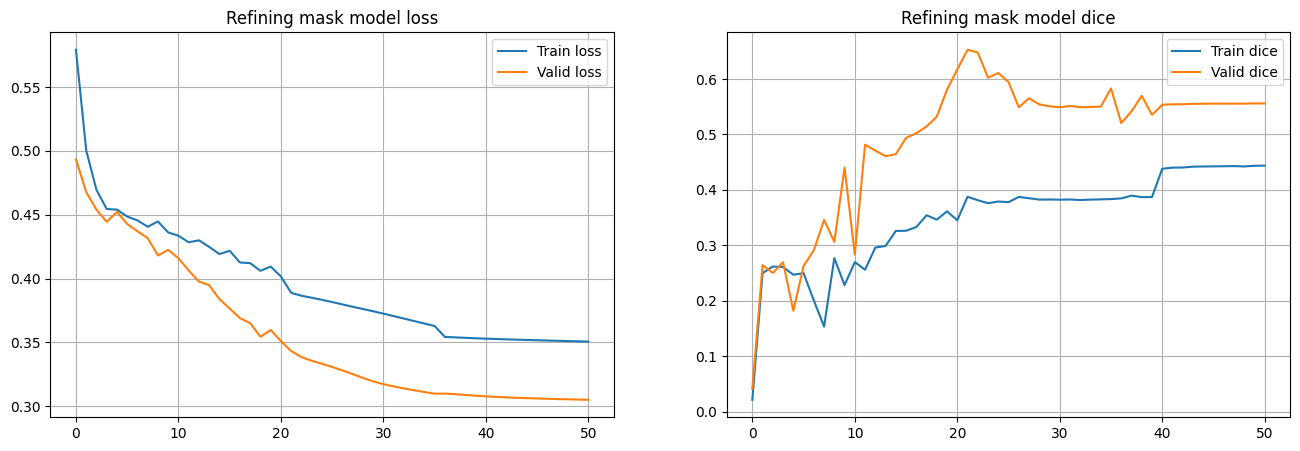

CPU times: total: 23min 26s
Wall time: 3min 55s


In [29]:
%%time

model = UpMemoryNet(memory_bank, min_distances).to(device)
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = MultiStepLR(
    optimizer,
    milestones=[21, 36],
    gamma=0.1
)

whole_train_valid_cycle(model, 51, 'Refining mask model', segm_train_loader, segm_test_loader, segm_val_loader, optimizer, loss_fn, scheduler)

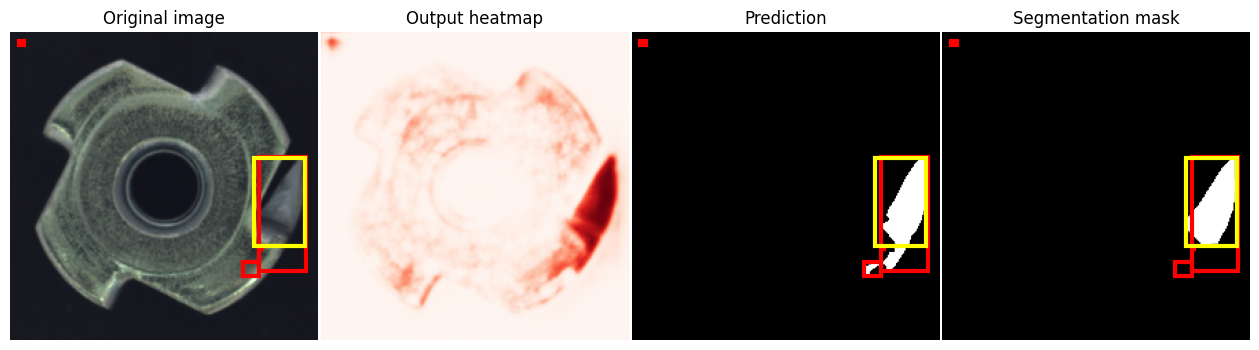

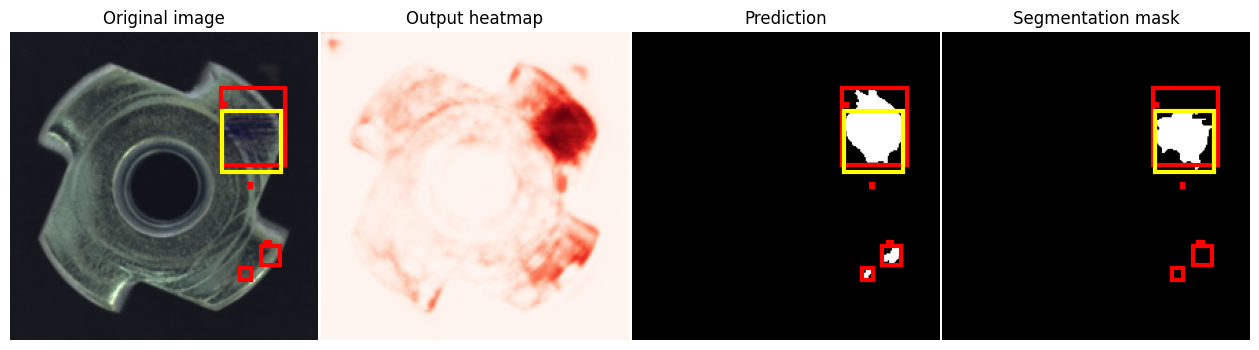

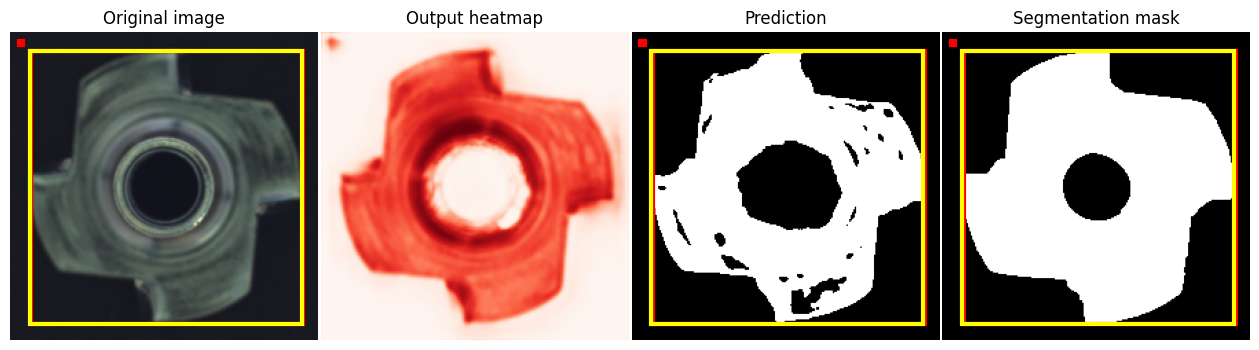

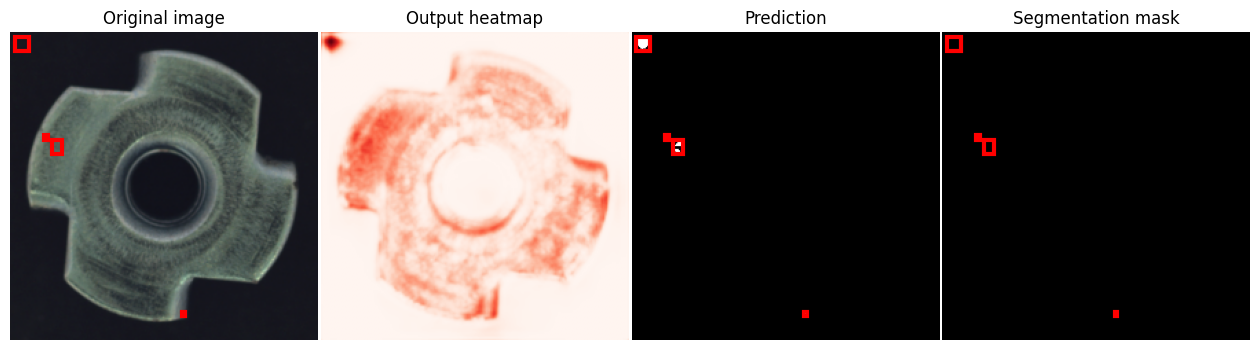

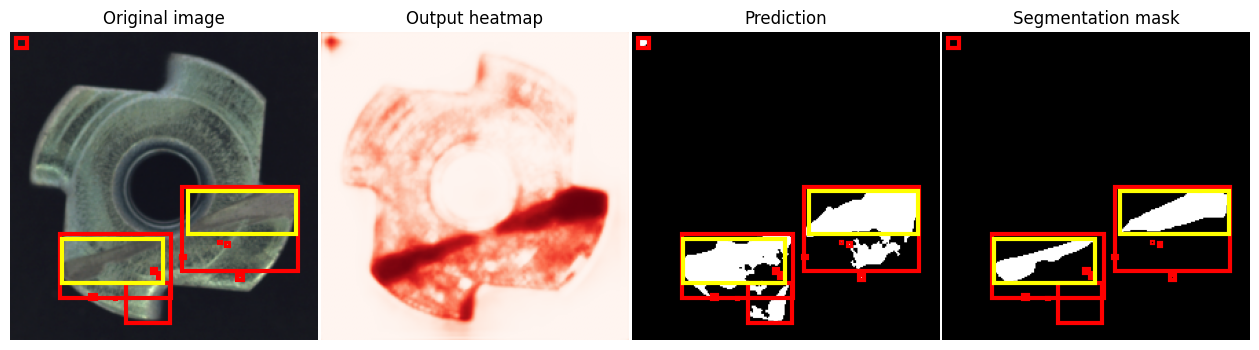

In [30]:
for batch in visualize_loader:
    break
visualize(model, batch, model.threshold)

In [31]:
with torch.no_grad():
    model.eval().to(device)
    total_metric = 0
    for i, batch in enumerate(segm_test_loader):
        total_metric += dice_metric(
            model(batch['image'].to(device)).cpu(), 
            batch['mask'].cpu().float()
        )
    total_metric /= (i+1)
print(f"Dice score on test sample: {total_metric:.4f}")

Dice score on test sample: 0.5328


The Dice score of the model with the refined mask is higher than that of the original PatchCore model (0.53 vs. 0.27). However, the refined model still tends to produce small false-positive defects in its predicted masks.

To mitigate this issue, one option is to slightly adjust the decision threshold or introduce an explicit penalty for producing too many defect regions. Another approach is to compute the average defect size on the segm_train_set and then filter predictions: if a detected region is significantly smaller than the dataset’s mean defect size and its heatmap confidence is close to the threshold, the region can be discarded.

In [32]:
def calcualte_defect_sizes(masks, sizes=None):
    if not sizes:
        sizes = []
    for mask in masks:
        mask = mask.squeeze()
        labels = measure.label(mask, connectivity=2)
        sizes += [int(r.area.item()) for r in measure.regionprops(labels)]
    return sizes

def explore_dataset_for_defects(loader):
    sizes = []
    for batch in loader:
        sizes += calcualte_defect_sizes(batch['mask'], sizes)
    return sizes

In [33]:
sizes = np.array(explore_dataset_for_defects(segm_train_loader))

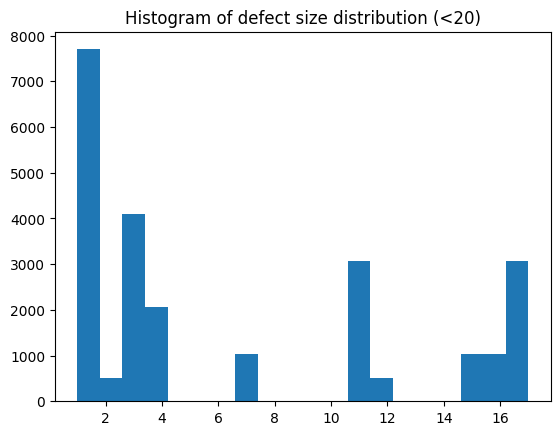

In [34]:
plt.hist(sizes[sizes<20], bins=20)
plt.title('Histogram of defect size distribution (<20)')
plt.show()

The dataset contains many 1-pixel defects